   # **ECS659U/P Coursework**

### **References**
1. **Tolstikhin I., Houlsby N., Kolesnikov A., Beyer L., Zhai X., Unterthiner T., Yung J., Steiner A., Keysers D., Uszkoreit J., Lucic M., Dosovitskiy A. (2021).** MLP-Mixer: An all-MLP Architecture for Vision. Google Research, Brain Team. Available at: https://arxiv.org/pdf/2105.01601.pdf. 

2. **Yu T., Li X., Cai Y., Sun M., Li P. (2021).** Rethinking Token-Mixing MLP for MLP-based Vision Backbone. Cognitive Computing Lab, Baidu Research. Available at: https://arxiv.org/pdf/2106.14882.pdf.

3. **Kilcher Y. (2021).** MLP-Mixer: An all-MLP Architecture for Vision (Machine Learning Research Paper Explained). YouTube video. Available at: https://www.youtube.com/watch?v=7K4Z8RqjWIk. 

4. **Tsang S.H. (2021.** Review - MLP-Mixer: An all-MLP Architecture for Vision. Article. Available at: https://sh-tsang.medium.com/review-mlp-mixer-an-all-mlp-architecture-for-vision-83e1f65452c9.

5. **Krishna, D.N. (2021).** MLP-Mixer: An all-MLP Architecture for Vision + Code. YouTube video. Available at: https://www.youtube.com/watch?v=-UHU61AMeZw.

6. **The AI Epiphany. (2021).** MLP-Mixer: An all-MLP Architecture for Vision | Paper Explained. YouTube video. Available at: https://www.youtube.com/watch?v=AoKf3SvvTIU.

7. **rrmina/MLP-Mixer-pytorch GitHub repository.** Available at: https://github.com/rrmina/MLP-Mixer-pytorch.

8. **mayurbhangale/fashion-mnist-pytorch GitHub repository.** Available at: https://github.com/mayurbhangale/fashion-mnist-pytorch/blob/master/CNN_Fashion_MNIST.ipynb.

9. **jeonsworld/MLP-Mixer-PyTorch GitHub repository.** Available at: https://github.com/jeonsworld/MLP-Mixer-Pytorch/blob/main/models/modeling.py.

10. **KrishnaDN/MLP-Mixer-PyTorch GitHub Repository.** Available at: https://github.com/KrishnaDN/MLP-Mixer-Pytorch/blob/main/mlp_mixer.py.

11. **mildlyoverfitted. (2021)** MLP-Mix in Flax and PyTorch. YouTube video. Available at: https://www.youtube.com/watch?v=HqytB2GUbHA.

In [1]:
pip install einops

You should consider upgrading via the '/Users/adamtoth/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.optim as optim
from torch import nn
from einops.layers.torch import Rearrange
import einops
import torch.functional as F

## **About the Model's Architecture - Stem, Backbone, Classifier**
#### **Source: Yu et. al. (2021)**

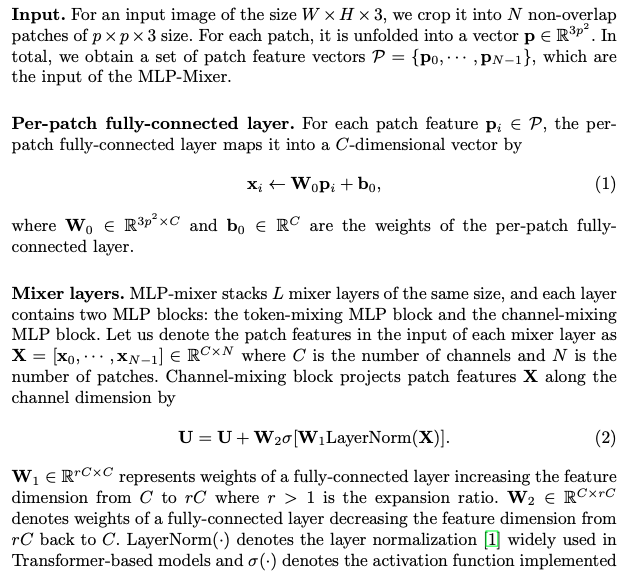
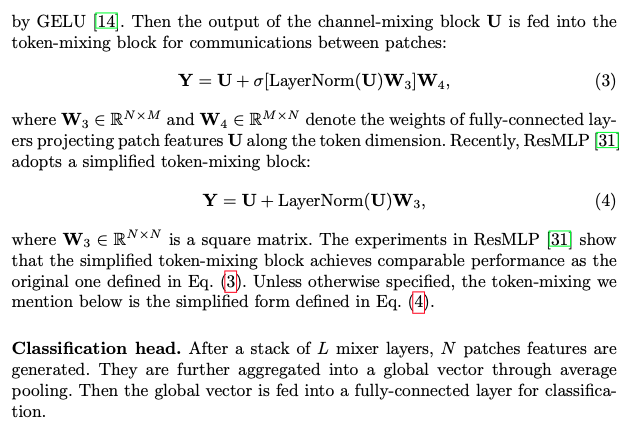

## **Backbone with Two MLPs**

In [3]:
# Creating the Backbone part with two MLPs. 

# Code is highly influenced by 'KrishnaDN/MLP-Mixer-PyTorch'.

# The first one takes as input the patches whose shapes were already been rearranged.
# It feeds its output into the second MLP. The process repeats as many times as many 
# layers of there are of the Backbone part. 

class BackBone(nn.Module):

    def __init__(self, dim, num_patches):
        super().__init__() 
        """
        Two normalisation layers applied to the batches for greater stability.
        """
        self.normalisation = nn.LayerNorm(dim)
        self.normalisation_2 = nn.LayerNorm(dim)
        self.first_mlp = nn.Sequential(
                                nn.Linear(num_patches, dim),
                                nn.ReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(dim, num_patches),
                                nn.Dropout(0.1)
                                )
        
        self.second_mlp = nn.Sequential(
                                nn.Linear(dim, dim),
                                nn.ReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(dim, dim),
                                nn.Dropout(0.1)
                                )
        
    def forward(self, x):
        # Layer Normalisation on Input X
        normalisation = self.normalisation(x)
        # Linear Projection on Transposed Normalised input with ReLU activation function
        firstmlp_out = self.first_mlp(normalisation.transpose(1,2)).transpose(1,2)
        #
        normalisation_2 = self.normalisation_2(firstmlp_out)
        secondmlp_out = self.second_mlp(firstmlp_out)
        return secondmlp_out

## **Attaching Backbone to Stem and Classifier**

In [4]:
# Code is highly influenced by 'KrishnaDN/MLP-Mixer-PyTorch' and his explanation through his YouTube video.



class MLPsTogether(nn.Module):
    def __init__(self, input_size, patch_size, dim=49, img_channel=1, layers=2, num_classes=10):
        super().__init__()
        num_patches = int(input_size[0] / patch_size[0] * input_size[1] / patch_size[1])
        patch_dim = img_channel * patch_size[0] * patch_size[1]
        
        """
        Below is the Stem part of the Model. The initial shape of extracted patches are being transformed here
        through using 'einops's Rearrange function and transposition, in order to be able to feed into the 
        Backbone's part first MLP. 
        """
        self.stem = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1]),
                nn.Linear(patch_dim, dim))
        
        """
        Connecting already written network of Backbone to Stem. 'Layers=2' is set to the minimum required 
        blocks number by the coursework. 
        """
        self.backbone = nn.Sequential(*[nn.Sequential(BackBone(dim, num_patches)) for _ in range(layers)])
        
        """Computing the mean feature for all input planes separately."""
        self.mean_feature = nn.AdaptiveAvgPool1d(1)
        
        """Classifier Layer"""
        self.classifier = nn.Linear(dim,num_classes)
        
    def forward(self, x):
        x = self.stem(x)
        x = self.backbone(x)
        return self.classifier(self.mean_feature(x.transpose(1,2)).squeeze(2))

In [5]:
import my_utils as mu

In [6]:
# Specifying batch_size being used
batch_size = 256

# Reading the Dataset, and creating the data loaders for training and testing
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

In [7]:
X, y = next(iter(train_iter)) # first batch
print(X.size())

torch.Size([256, 1, 28, 28])


In [8]:
# Xavier Weight Initialisation
def init_weights(m):
    if type(m) == nn.Linear: 
        torch.nn.init.xavier_uniform_(m.weight)          

# Instantiate the Model and applying the weights to it
model = MLPsTogether(input_size=(28,28), patch_size=(4,4))
model.apply(init_weights)

MLPsTogether(
  (stem): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=49, bias=True)
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): BackBone(
        (normalisation): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
        (normalisation_2): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
        (first_mlp): Sequential(
          (0): Linear(in_features=49, out_features=49, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=49, out_features=49, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (second_mlp): Sequential(
          (0): Linear(in_features=49, out_features=49, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=49, out_features=49, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Seq

In [9]:
# Creating Adam Optimizer with learning rate=0.001
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Setting up Cross Entropy Loss function
loss = nn.CrossEntropyLoss()

In [10]:
# Training the Model
def train(model, train_iter, optimizer, criterion):
    model.train()
    total_loss, total_num, correct = 0, 0, 0
    for x,y in train_iter:
        batch_size = x.shape[0]
        
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        optimizer.zero_grad()      # Clear gradients w.r.t. parameters
        out = model(x)             # Forward pass to get output
        loss = criterion(out, y)   # Calculate Loss: Softmax -> Cross Entropy Loss
        loss.backward()            # Getting gradients w.r.t. parameters
        optimizer.step()           # Updating the parameters

        pred = out.argmax(dim=1, keepdim=True) # Get predictions from the maximum value

        correct    += pred.eq(y.view_as(pred)).sum().item()
        total_loss += loss.data.cpu().numpy().item()*batch_size
        total_num  += batch_size

    acc = 100. * correct / total_num
    final_loss = total_loss / total_num
    return final_loss, acc

In [11]:
# Testing the Model
def test(model, test_iter, criterion):
    model.eval()
    total_loss, total_num, correct = 0, 0, 0
    with torch.no_grad():
        for x,y in test_iter:
            batch_size = x.shape[0]

            if len(x.shape) == 3:
                x = x.unsqueeze(1)

            out = model(x)
            loss = criterion(out, y)
            pred = out.argmax(dim=1, keepdim=True) 

            correct    += pred.eq(y.view_as(pred)).sum().item()
            total_loss += loss.data.cpu().numpy().item()*batch_size
            total_num  += batch_size

    acc = 100. * correct / total_num
    final_loss = total_loss / total_num
    return final_loss, acc

In [12]:
# Using 20 epochs to train/test the model
for epoch in range(20):
    tr_loss, tr_acc = train(model, train_iter, optimizer, loss)
    te_loss, te_acc = test(model, test_iter, loss)

    print('Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% | Test: loss={:.3f}, acc={:5.1f}%'.format(
        epoch+1, tr_loss, tr_acc, te_loss, te_acc))

In [13]:
# Animation Class imported from my_utils, provided by Module ECS6P9U/P Neural Networks & Deep Learning
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
# Animation Class imported from my_utils, provided by Module ECS6P9U/P Neural Networks & Deep Learning
# Training class outputting training, testing loss and accuracy with incremental animation of each 

def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics

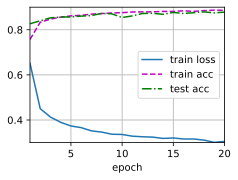

In [15]:
num_epochs = 20
a = mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)